# DLA Patterns in Bacteria and Slime Molds

This notebook explores Diffusion-Limited Aggregation (DLA) patterns observed in microbial systems, including bacterial colonies and the remarkable *Physarum polycephalum* slime mold. These organisms demonstrate that DLA is a universal growth mechanism when nutrient diffusion limits colony expansion.

## Key References

- **Fujikawa & Matsushita (1989)**: Discovered that *Bacillus subtilis* colonies exhibit fractal dimension D = 1.716, matching theoretical DLA
- **Ben-Jacob et al. (1994)**: Developed morphology phase diagram for bacterial colony patterns
- **Nakagaki et al. (2000)**: Demonstrated maze-solving by *Physarum polycephalum*
- **Jones (2010)**: Multi-agent model for Physarum network formation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import laplace, uniform_filter, binary_dilation
from scipy.spatial import KDTree
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 100

---

## 1. Bacterial Colony DLA (Fujikawa-Matsushita Model)

The seminal 1989 discovery showed that *Bacillus subtilis* grown on nutrient-poor agar exhibits true DLA fractal patterns with D ≈ 1.71. The key insight is that when nutrients are scarce, diffusion becomes the rate-limiting step for growth, producing the same mathematics as electrochemical deposition.

### The Screening Effect

Interior branches stop growing despite having open neighborhoods - protruding tips "screen" inner regions from nutrient flux, exactly as predicted by DLA theory.

In [2]:
def bacterial_dla(num_particles=3000, grid_size=401, sticking_prob=1.0):
    """
    Simulate bacterial colony growth via DLA.
    
    Parameters:
    -----------
    num_particles : int
        Number of particles (cells) to add
    grid_size : int
        Size of the simulation grid
    sticking_prob : float
        Probability of sticking on contact (1.0 = pure DLA, <1.0 = denser colonies)
    
    Returns:
    --------
    grid : np.ndarray
        Binary grid with colony pattern
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.uint8)
    center = grid_size // 2
    
    # Seed colony at center
    grid[center, center] = 1
    
    # Neighbor offsets (4-connected)
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    
    max_radius = 1
    birth_offset = 5
    kill_offset = 50
    
    particles_added = 0
    
    while particles_added < num_particles:
        # Spawn walker on circle around colony
        angle = np.random.uniform(0, 2 * np.pi)
        birth_r = max_radius + birth_offset
        x = int(center + birth_r * np.cos(angle))
        y = int(center + birth_r * np.sin(angle))
        
        # Random walk until attachment or escape
        while True:
            # Random step
            dx, dy = neighbors[np.random.randint(4)]
            x, y = x + dx, y + dy
            
            # Check kill radius
            dist_sq = (x - center)**2 + (y - center)**2
            if dist_sq > (max_radius + kill_offset)**2:
                break
            
            # Check bounds
            if not (1 <= x < grid_size-1 and 1 <= y < grid_size-1):
                break
            
            # Check for neighbor contact
            has_neighbor = False
            for nx, ny in neighbors:
                if grid[x + nx, y + ny]:
                    has_neighbor = True
                    break
            
            if has_neighbor:
                # Sticking probability
                if np.random.random() < sticking_prob:
                    grid[x, y] = 1
                    particles_added += 1
                    r = np.sqrt(dist_sq)
                    max_radius = max(max_radius, int(r) + 1)
                    
                    if particles_added % 500 == 0:
                        print(f"  Added {particles_added}/{num_particles} cells, radius={max_radius}")
                    break
    
    return grid

Simulating bacterial DLA colony (pure DLA, sticking_prob=1.0)...
  Added 500/5000 cells, radius=42
  Added 1000/5000 cells, radius=62
  Added 1500/5000 cells, radius=77
  Added 2000/5000 cells, radius=90
  Added 2500/5000 cells, radius=100
  Added 3000/5000 cells, radius=106
  Added 3500/5000 cells, radius=112
  Added 4000/5000 cells, radius=120
  Added 4500/5000 cells, radius=130
  Added 5000/5000 cells, radius=140


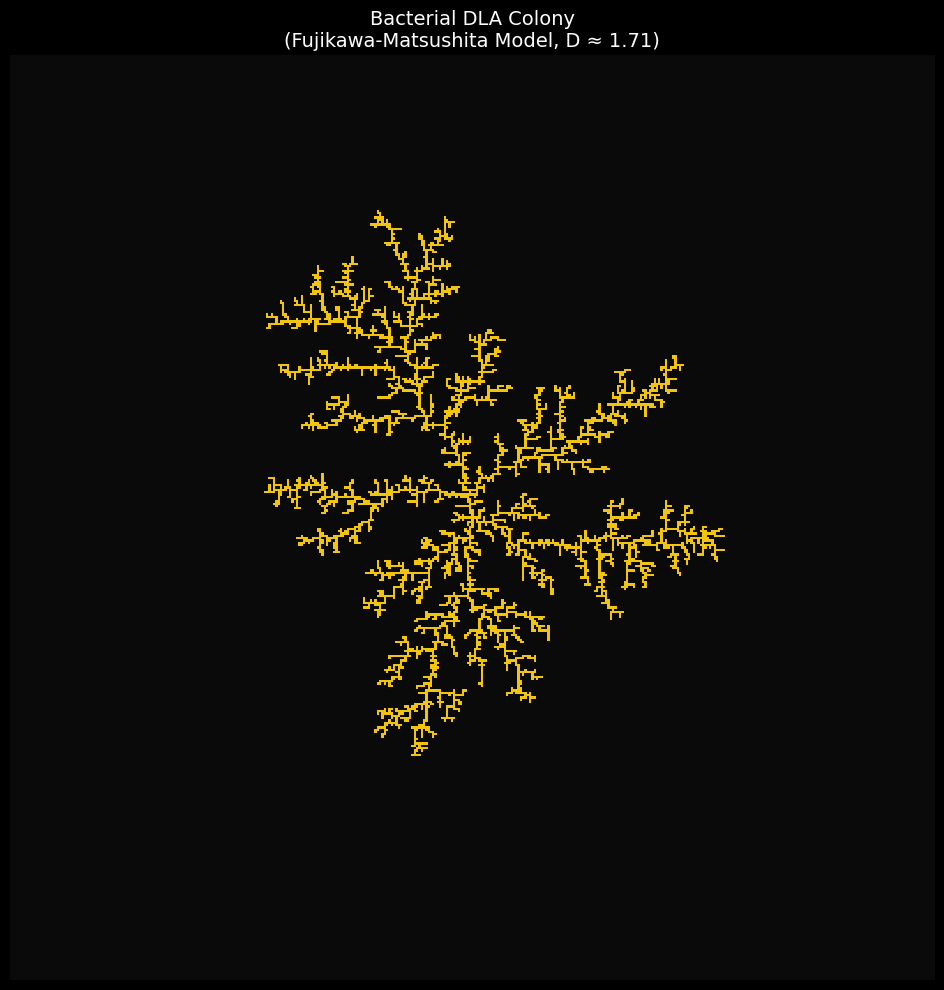


Colony statistics:
  Total cells: 5001


In [3]:
print("Simulating bacterial DLA colony (pure DLA, sticking_prob=1.0)...")
colony_dla = bacterial_dla(num_particles=5000, sticking_prob=1.0)

# Custom colormap: dark background with bright colony
bacteria_cmap = LinearSegmentedColormap.from_list('bacteria', 
    ['#0a0a0a', '#1a5f1a', '#2ecc71', '#f1c40f'])

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(colony_dla, cmap=bacteria_cmap, interpolation='nearest')
ax.set_title('Bacterial DLA Colony\n(Fujikawa-Matsushita Model, D ≈ 1.71)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nColony statistics:")
print(f"  Total cells: {colony_dla.sum()}")

---

## 2. Ben-Jacob Morphology Diagram

Eshel Ben-Jacob developed a phase diagram showing how bacterial colony patterns vary with nutrient concentration and agar hardness. Let's simulate different regimes:

| Region | Nutrients | Agar | Pattern |
|--------|-----------|------|--------|
| DLA-like | Low | Hard | Fractal branching (D ≈ 1.7) |
| Eden-like | High | Hard | Compact with fractal boundary |
| DBM | Low | Medium | Dense Branching Morphology |

Simulating Pure DLA (p=1.0)...
  Added 500/2500 cells, radius=35
  Added 1000/2500 cells, radius=47
  Added 1500/2500 cells, radius=60
  Added 2000/2500 cells, radius=71
  Added 2500/2500 cells, radius=89
Simulating DBM-like (p=0.3)...
  Added 500/2500 cells, radius=27
  Added 1000/2500 cells, radius=41
  Added 1500/2500 cells, radius=47
  Added 2000/2500 cells, radius=55
  Added 2500/2500 cells, radius=58
Simulating Transitional (p=0.1)...
  Added 500/2500 cells, radius=20
  Added 1000/2500 cells, radius=28
  Added 1500/2500 cells, radius=35
  Added 2000/2500 cells, radius=42
  Added 2500/2500 cells, radius=45
Simulating Eden-like (p=0.03)...
  Added 500/2500 cells, radius=13
  Added 1000/2500 cells, radius=22
  Added 1500/2500 cells, radius=27
  Added 2000/2500 cells, radius=32
  Added 2500/2500 cells, radius=37


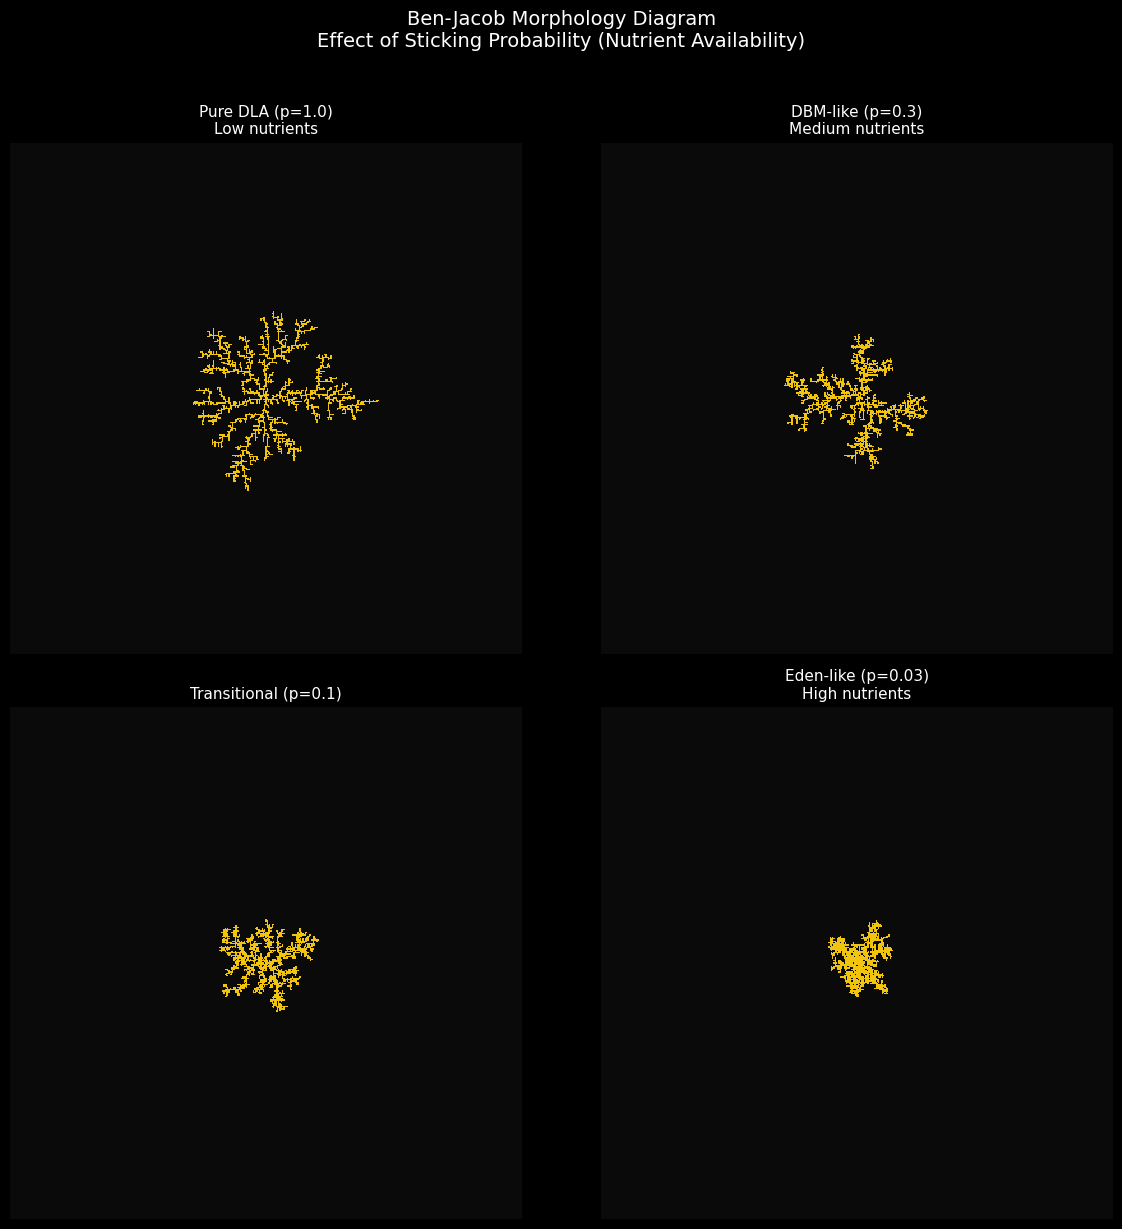

In [4]:
def compare_morphologies(num_particles=3000):
    """Compare different sticking probabilities to simulate morphology transitions."""
    
    sticking_probs = [1.0, 0.3, 0.1, 0.03]
    labels = ['Pure DLA (p=1.0)\nLow nutrients', 
              'DBM-like (p=0.3)\nMedium nutrients',
              'Transitional (p=0.1)', 
              'Eden-like (p=0.03)\nHigh nutrients']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for idx, (p, label) in enumerate(zip(sticking_probs, labels)):
        print(f"Simulating {label.split(chr(10))[0]}...")
        colony = bacterial_dla(num_particles=num_particles, sticking_prob=p)
        
        ax = axes[idx // 2, idx % 2]
        ax.imshow(colony, cmap=bacteria_cmap, interpolation='nearest')
        ax.set_title(label, fontsize=11)
        ax.axis('off')
    
    plt.suptitle('Ben-Jacob Morphology Diagram\nEffect of Sticking Probability (Nutrient Availability)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

compare_morphologies(num_particles=2500)

---

## 3. Bacterial Swarming Model

Dendritic swarming patterns arise from a combination of DLA-like nutrient limitation and active bacterial motility. This is modeled using reaction-diffusion equations coupled with chemotaxis.

Key features:
- Nutrient diffusion and consumption
- Bacterial growth proportional to local nutrients
- Surfactant production enables swarming on hard agar
- Stochastic noise drives branching instability

In [5]:
def bacterial_swarming_model(grid_size=300, 
                              num_steps=500,
                              nutrient_initial=1.0,
                              diffusion_rate=0.2,
                              consumption_rate=0.08,
                              growth_rate=0.15,
                              noise_amplitude=0.02):
    """
    Hybrid DLA + active motility model for bacterial swarming.
    
    Based on Kawasaki et al. (1997) reaction-diffusion model.
    
    Returns:
    --------
    bacteria : np.ndarray
        Bacterial density field
    nutrients : np.ndarray
        Nutrient concentration field
    history : list
        Snapshots for animation
    """
    # Initialize fields
    bacteria = np.zeros((grid_size, grid_size))
    nutrients = np.ones((grid_size, grid_size)) * nutrient_initial
    
    # Seed colony at center
    center = grid_size // 2
    r = 5
    y, x = np.ogrid[-center:grid_size-center, -center:grid_size-center]
    mask = x*x + y*y <= r*r
    bacteria[mask] = 0.8
    
    dt = 0.5
    history = [bacteria.copy()]
    
    for step in range(num_steps):
        # Nutrient diffusion (Laplacian)
        nutrient_lap = laplace(nutrients)
        
        # Nutrient consumption by bacteria
        consumption = consumption_rate * bacteria * nutrients
        
        # Bacterial growth (logistic, nutrient-dependent)
        growth = growth_rate * bacteria * nutrients * (1 - bacteria)
        
        # Bacterial diffusion (motility)
        bacteria_lap = laplace(bacteria)
        
        # Update fields
        nutrients += dt * (diffusion_rate * nutrient_lap - consumption)
        nutrients = np.clip(nutrients, 0, nutrient_initial)
        
        bacteria += dt * (growth + 0.01 * bacteria_lap)
        
        # Add stochastic noise for branching instability
        if step % 10 == 0:
            noise = np.random.normal(0, noise_amplitude, bacteria.shape)
            edge_mask = (bacteria > 0.1) & (bacteria < 0.7)
            bacteria += noise * edge_mask
            bacteria = np.clip(bacteria, 0, 1)
        
        if step % 25 == 0:
            history.append(bacteria.copy())
    
    return bacteria, nutrients, history

Running bacterial swarming simulation...


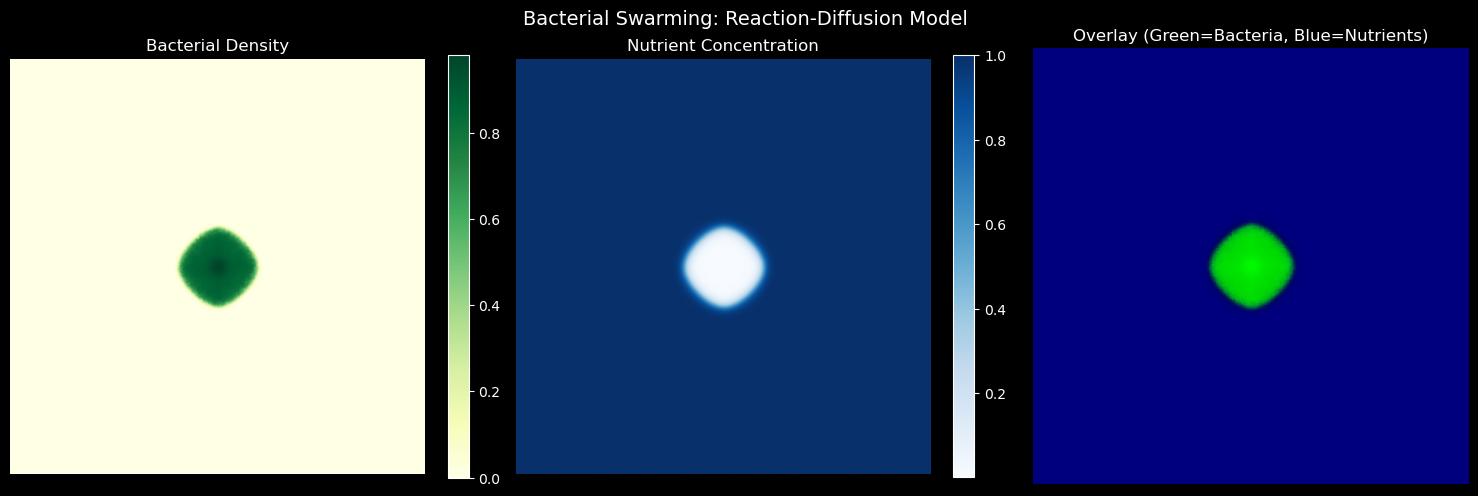

In [6]:
print("Running bacterial swarming simulation...")
bacteria, nutrients, history = bacterial_swarming_model(grid_size=300, num_steps=600)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bacterial density
im1 = axes[0].imshow(bacteria, cmap='YlGn', interpolation='bilinear')
axes[0].set_title('Bacterial Density', fontsize=12)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Nutrient field
im2 = axes[1].imshow(nutrients, cmap='Blues', interpolation='bilinear')
axes[1].set_title('Nutrient Concentration', fontsize=12)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# Overlay
overlay = np.zeros((*bacteria.shape, 3))
overlay[:,:,1] = bacteria  # Green channel for bacteria
overlay[:,:,2] = nutrients * 0.5  # Blue channel for nutrients
axes[2].imshow(overlay)
axes[2].set_title('Overlay (Green=Bacteria, Blue=Nutrients)', fontsize=12)
axes[2].axis('off')

plt.suptitle('Bacterial Swarming: Reaction-Diffusion Model', fontsize=14)
plt.tight_layout()
plt.show()

---

## 4. *Physarum polycephalum* Network Formation

*Physarum polycephalum* is a single-celled slime mold that forms remarkable transport networks. Unlike DLA, Physarum uses **adaptive network optimization** - it can solve mazes, find shortest paths, and create networks rivaling human-designed infrastructure.

### Agent-Based Model

Following Jones (2010), we model Physarum using multiple agents that:
1. Sense chemoattractant in three directions (front, front-left, front-right)
2. Turn toward higher concentrations
3. Deposit chemoattractant at their current position
4. Trail diffuses and decays over time

In [7]:
class PhysarumAgent:
    """Single Physarum agent with position, heading, and sensory capabilities."""
    
    def __init__(self, x, y, heading, grid_size):
        self.x = x
        self.y = y
        self.heading = heading
        self.grid_size = grid_size
    
    def sense(self, trail_map, sensor_angle, sensor_distance):
        """Sense chemoattractant at front, front-left, and front-right."""
        sa = np.radians(sensor_angle)
        
        # Front sensor
        fx = int(self.x + sensor_distance * np.cos(self.heading)) % self.grid_size
        fy = int(self.y + sensor_distance * np.sin(self.heading)) % self.grid_size
        f = trail_map[fy, fx]
        
        # Front-left sensor
        fl_x = int(self.x + sensor_distance * np.cos(self.heading + sa)) % self.grid_size
        fl_y = int(self.y + sensor_distance * np.sin(self.heading + sa)) % self.grid_size
        fl = trail_map[fl_y, fl_x]
        
        # Front-right sensor
        fr_x = int(self.x + sensor_distance * np.cos(self.heading - sa)) % self.grid_size
        fr_y = int(self.y + sensor_distance * np.sin(self.heading - sa)) % self.grid_size
        fr = trail_map[fr_y, fr_x]
        
        return f, fl, fr
    
    def rotate_and_move(self, trail_map, sensor_angle, sensor_distance, 
                        rotation_angle, step_size=1.0):
        """Sense, rotate toward attractant, and move forward."""
        f, fl, fr = self.sense(trail_map, sensor_angle, sensor_distance)
        ra = np.radians(rotation_angle)
        
        # Rotation decision
        if f > fl and f > fr:
            pass  # Continue straight
        elif f < fl and f < fr:
            # Random turn when front is weakest
            if np.random.random() < 0.5:
                self.heading += ra
            else:
                self.heading -= ra
        elif fl < fr:
            self.heading -= ra  # Turn right
        elif fr < fl:
            self.heading += ra  # Turn left
        # Equal case: continue straight
        
        # Normalize heading
        self.heading = self.heading % (2 * np.pi)
        
        # Move forward
        self.x = (self.x + step_size * np.cos(self.heading)) % self.grid_size
        self.y = (self.y + step_size * np.sin(self.heading)) % self.grid_size

In [8]:
def physarum_simulation(num_agents=5000, 
                         grid_size=200,
                         num_steps=500,
                         sensor_angle=22.5,
                         rotation_angle=45,
                         sensor_distance=9,
                         deposit_amount=5,
                         decay_rate=0.1,
                         diffusion_kernel=3):
    """
    Multi-agent model approximating Physarum network formation.
    
    Parameters:
    -----------
    num_agents : int
        Number of Physarum agents
    grid_size : int
        Size of simulation grid
    sensor_angle : float
        Angle between front and side sensors (degrees)
    rotation_angle : float
        Rotation amount when turning (degrees)
    sensor_distance : float
        Distance to sensor positions
    deposit_amount : float
        Amount of chemoattractant deposited per step
    decay_rate : float
        Trail decay rate per step
    
    Returns:
    --------
    trail_map : np.ndarray
        Final chemoattractant concentration
    agents : list
        List of PhysarumAgent objects
    history : list
        Snapshots for animation
    """
    # Initialize agents in center region with random headings
    center = grid_size // 2
    spawn_radius = grid_size * 0.1
    
    agents = []
    for _ in range(num_agents):
        # Spawn in disk at center
        r = np.random.uniform(0, spawn_radius)
        theta = np.random.uniform(0, 2 * np.pi)
        x = center + r * np.cos(theta)
        y = center + r * np.sin(theta)
        heading = np.random.uniform(0, 2 * np.pi)
        agents.append(PhysarumAgent(x, y, heading, grid_size))
    
    # Trail map
    trail_map = np.zeros((grid_size, grid_size))
    
    history = []
    
    for step in range(num_steps):
        # Move all agents
        for agent in agents:
            agent.rotate_and_move(trail_map, sensor_angle, sensor_distance, rotation_angle)
            
            # Deposit chemoattractant
            ix, iy = int(agent.x), int(agent.y)
            trail_map[iy, ix] += deposit_amount
        
        # Diffuse trail
        trail_map = uniform_filter(trail_map, size=diffusion_kernel)
        
        # Decay trail
        trail_map *= (1 - decay_rate)
        
        # Clamp maximum
        trail_map = np.clip(trail_map, 0, 255)
        
        if step % 25 == 0:
            history.append(trail_map.copy())
            if step % 100 == 0:
                print(f"  Step {step}/{num_steps}")
    
    return trail_map, agents, history

Running Physarum simulation...
  Step 0/600
  Step 100/600
  Step 200/600
  Step 300/600
  Step 400/600
  Step 500/600


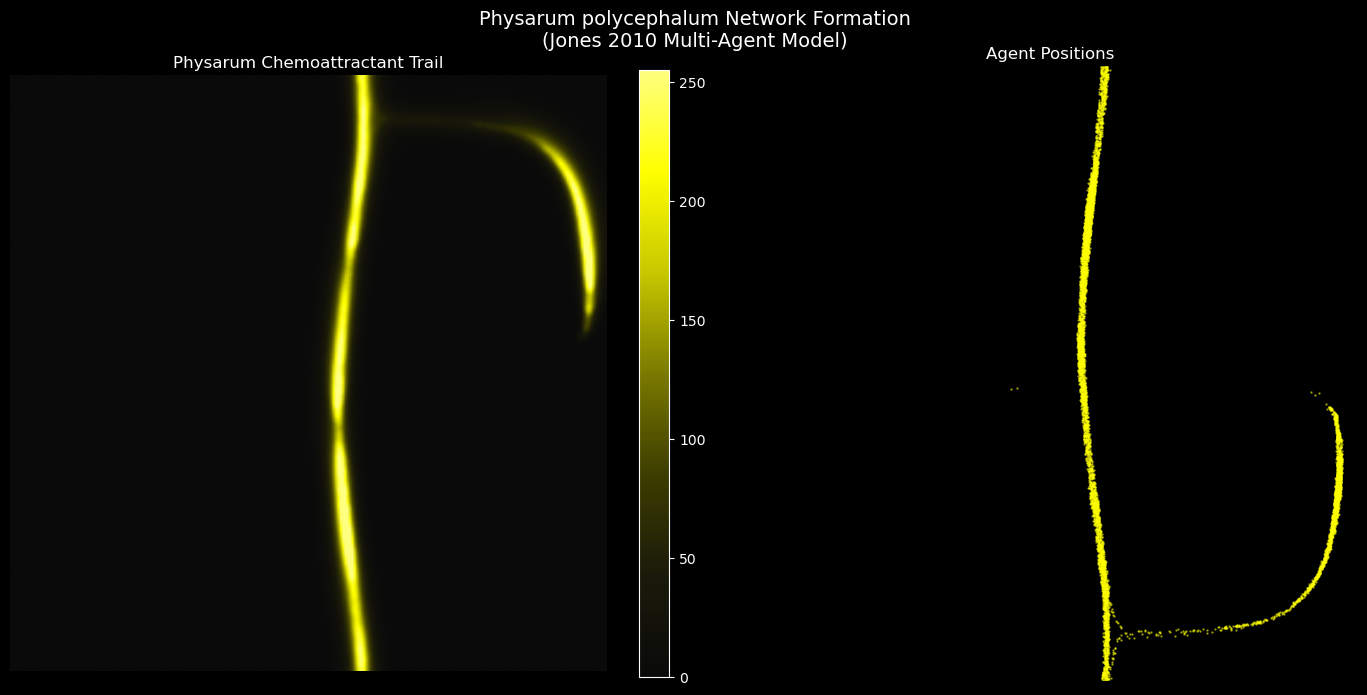

In [9]:
print("Running Physarum simulation...")
trail_map, agents, history = physarum_simulation(
    num_agents=8000, 
    grid_size=250,
    num_steps=600,
    sensor_angle=22.5,
    rotation_angle=45,
    deposit_amount=5,
    decay_rate=0.05
)

# Physarum-inspired colormap (yellow-orange network on dark background)
physarum_cmap = LinearSegmentedColormap.from_list('physarum', 
    ['#0a0a0a', '#1a1a0a', '#3d3d00', '#7a7a00', '#c7c700', '#ffff00', '#ffff80'])

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Trail map
im1 = axes[0].imshow(trail_map, cmap=physarum_cmap, interpolation='bilinear')
axes[0].set_title('Physarum Chemoattractant Trail', fontsize=12)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

# Agent positions
agent_x = [a.x for a in agents]
agent_y = [a.y for a in agents]
axes[1].scatter(agent_x, agent_y, s=0.5, c='yellow', alpha=0.5)
axes[1].set_xlim(0, 250)
axes[1].set_ylim(0, 250)
axes[1].set_aspect('equal')
axes[1].set_facecolor('#0a0a0a')
axes[1].set_title('Agent Positions', fontsize=12)
axes[1].axis('off')

plt.suptitle('Physarum polycephalum Network Formation\n(Jones 2010 Multi-Agent Model)', fontsize=14)
plt.tight_layout()
plt.show()

### Parameter Exploration

The Physarum model is highly sensitive to sensor and rotation angles. Let's explore different parameter regimes:

Running Default (SA=22.5, RA=45)...
  Step 0/400
  Step 100/400
  Step 200/400
  Step 300/400
Running Wide Sensing (SA=45, RA=45)...
  Step 0/400
  Step 100/400
  Step 200/400
  Step 300/400
Running Smooth Turns (SA=22.5, RA=22.5)...
  Step 0/400
  Step 100/400
  Step 200/400
  Step 300/400
Running Sharp Turns (SA=45, RA=90)...
  Step 0/400
  Step 100/400
  Step 200/400
  Step 300/400


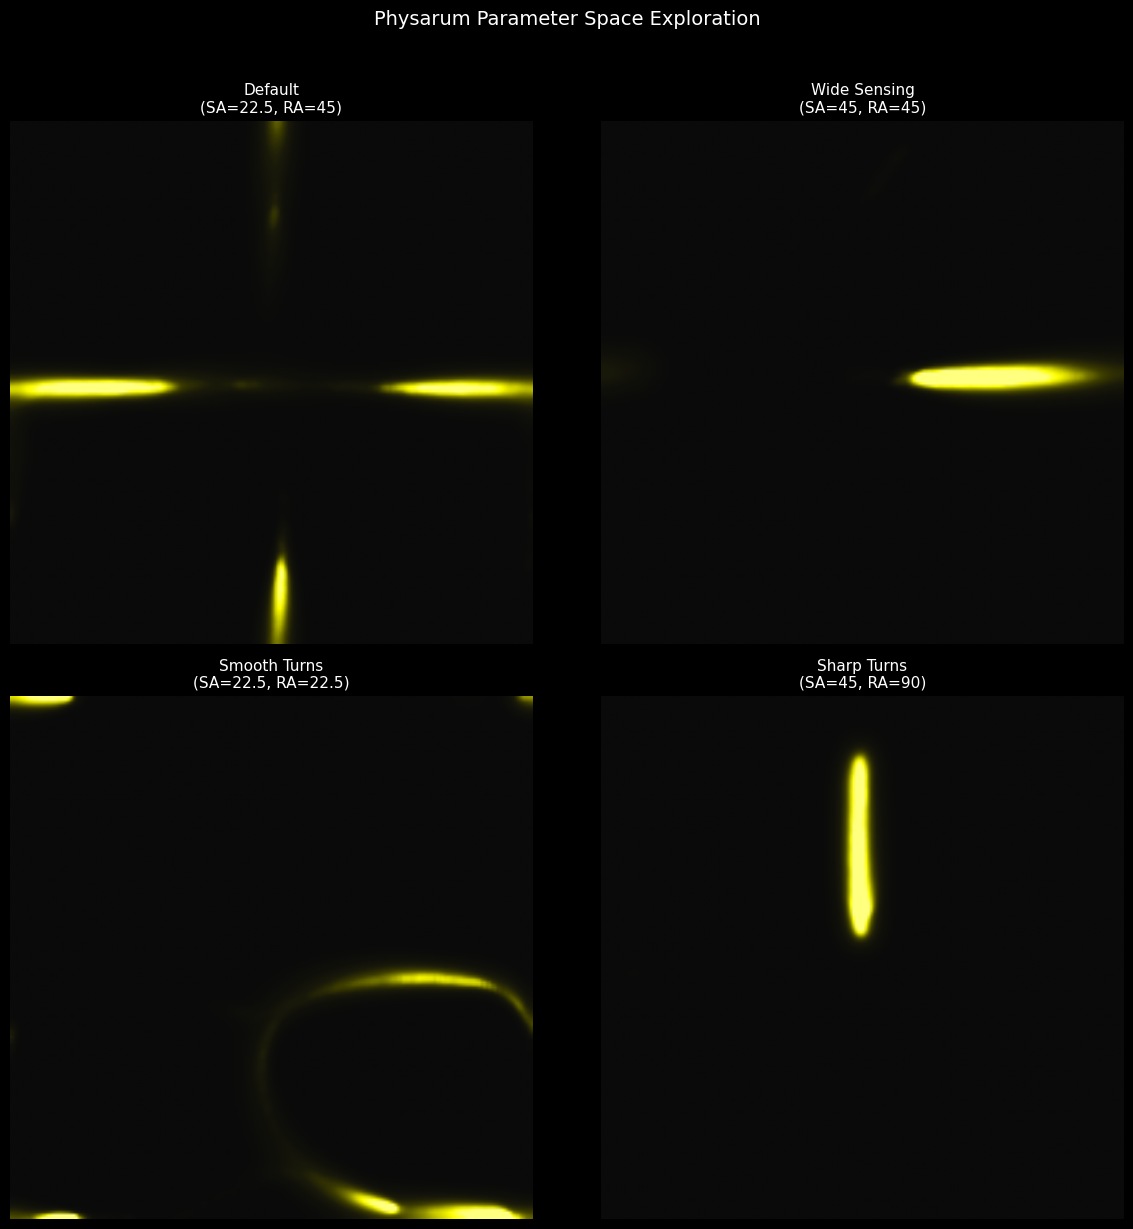

In [10]:
def explore_physarum_parameters():
    """Explore different Physarum parameter settings."""
    
    params = [
        {'sensor_angle': 22.5, 'rotation_angle': 45, 'label': 'Default\n(SA=22.5, RA=45)'},
        {'sensor_angle': 45, 'rotation_angle': 45, 'label': 'Wide Sensing\n(SA=45, RA=45)'},
        {'sensor_angle': 22.5, 'rotation_angle': 22.5, 'label': 'Smooth Turns\n(SA=22.5, RA=22.5)'},
        {'sensor_angle': 45, 'rotation_angle': 90, 'label': 'Sharp Turns\n(SA=45, RA=90)'},
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for idx, p in enumerate(params):
        print(f"Running {p['label'].replace(chr(10), ' ')}...")
        trail, _, _ = physarum_simulation(
            num_agents=5000,
            grid_size=200,
            num_steps=400,
            sensor_angle=p['sensor_angle'],
            rotation_angle=p['rotation_angle'],
            decay_rate=0.05
        )
        
        ax = axes[idx // 2, idx % 2]
        ax.imshow(trail, cmap=physarum_cmap, interpolation='bilinear')
        ax.set_title(p['label'], fontsize=11)
        ax.axis('off')
    
    plt.suptitle('Physarum Parameter Space Exploration', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

explore_physarum_parameters()

---

## 5. Physarum with Food Sources

One of Physarum's remarkable abilities is connecting food sources efficiently. Let's add food sources to attract agents:

In [11]:
def physarum_with_food(num_agents=8000, 
                        grid_size=250,
                        num_steps=800,
                        food_positions=None,
                        food_strength=50):
    """
    Physarum simulation with food sources.
    
    Food sources emit constant chemoattractant, attracting agents.
    """
    if food_positions is None:
        # Default: 5 food sources in a rough pentagon
        center = grid_size // 2
        r = grid_size * 0.35
        food_positions = []
        for i in range(5):
            angle = i * 2 * np.pi / 5 - np.pi/2
            fx = int(center + r * np.cos(angle))
            fy = int(center + r * np.sin(angle))
            food_positions.append((fx, fy))
    
    # Initialize agents scattered throughout
    agents = []
    for _ in range(num_agents):
        x = np.random.uniform(20, grid_size - 20)
        y = np.random.uniform(20, grid_size - 20)
        heading = np.random.uniform(0, 2 * np.pi)
        agents.append(PhysarumAgent(x, y, heading, grid_size))
    
    # Trail map
    trail_map = np.zeros((grid_size, grid_size))
    
    # Create food mask (for visualization)
    food_mask = np.zeros((grid_size, grid_size))
    for fx, fy in food_positions:
        y, x = np.ogrid[-fy:grid_size-fy, -fx:grid_size-fx]
        mask = x*x + y*y <= 10*10
        food_mask[mask] = 1
    
    sensor_angle = 22.5
    rotation_angle = 45
    sensor_distance = 9
    deposit_amount = 5
    decay_rate = 0.02
    
    history = []
    
    for step in range(num_steps):
        # Add food source attractant
        for fx, fy in food_positions:
            for dx in range(-8, 9):
                for dy in range(-8, 9):
                    nx, ny = (fx + dx) % grid_size, (fy + dy) % grid_size
                    if dx*dx + dy*dy <= 64:
                        trail_map[ny, nx] += food_strength
        
        # Move all agents
        for agent in agents:
            agent.rotate_and_move(trail_map, sensor_angle, sensor_distance, rotation_angle)
            ix, iy = int(agent.x), int(agent.y)
            trail_map[iy, ix] += deposit_amount
        
        # Diffuse and decay
        trail_map = uniform_filter(trail_map, size=3)
        trail_map *= (1 - decay_rate)
        trail_map = np.clip(trail_map, 0, 500)
        
        if step % 40 == 0:
            history.append(trail_map.copy())
            if step % 200 == 0:
                print(f"  Step {step}/{num_steps}")
    
    return trail_map, food_positions, food_mask, history

Running Physarum with food sources...
  Step 0/1000
  Step 200/1000
  Step 400/1000
  Step 600/1000
  Step 800/1000


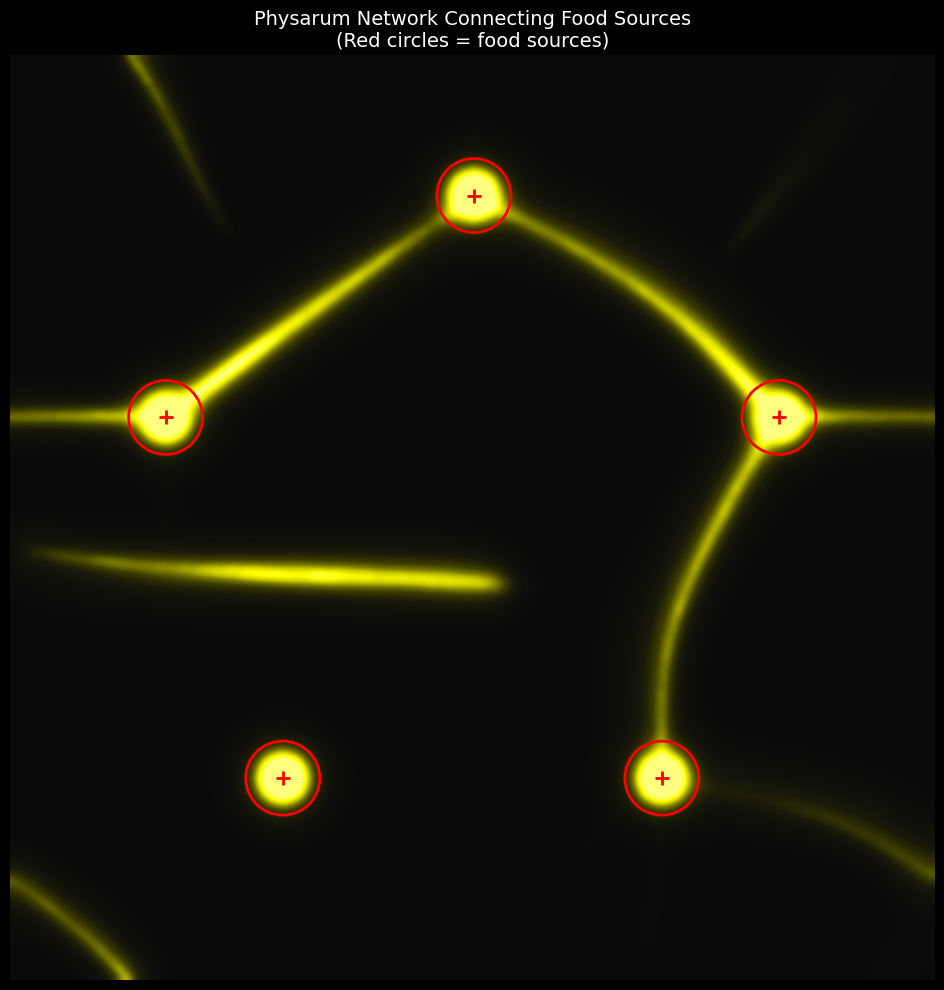

In [12]:
print("Running Physarum with food sources...")
trail_food, food_pos, food_mask, history_food = physarum_with_food(
    num_agents=10000,
    grid_size=300,
    num_steps=1000,
    food_strength=30
)

fig, ax = plt.subplots(figsize=(10, 10))

# Show trail
ax.imshow(trail_food, cmap=physarum_cmap, interpolation='bilinear')

# Mark food sources
for fx, fy in food_pos:
    circle = plt.Circle((fx, fy), 12, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.plot(fx, fy, 'r+', markersize=10, markeredgewidth=2)

ax.set_title('Physarum Network Connecting Food Sources\n(Red circles = food sources)', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

---

## 6. Fractal Dimension Analysis

Let's compute the fractal dimension of our simulated colonies using the **box-counting method**. The theoretical DLA value is D ≈ 1.71.

In [13]:
def box_counting_dimension(binary_image, min_box_size=2, max_box_size=None):
    """
    Estimate fractal dimension using box-counting method.
    
    Parameters:
    -----------
    binary_image : np.ndarray
        Binary image (0s and 1s)
    
    Returns:
    --------
    D : float
        Estimated fractal dimension
    box_sizes : np.ndarray
        Box sizes used
    counts : np.ndarray
        Number of boxes containing pattern at each scale
    """
    if max_box_size is None:
        max_box_size = min(binary_image.shape) // 4
    
    # Generate box sizes (powers of 2)
    box_sizes = []
    size = min_box_size
    while size <= max_box_size:
        box_sizes.append(size)
        size *= 2
    box_sizes = np.array(box_sizes)
    
    counts = []
    
    for box_size in box_sizes:
        # Count boxes containing at least one occupied cell
        n_boxes = 0
        for i in range(0, binary_image.shape[0], box_size):
            for j in range(0, binary_image.shape[1], box_size):
                box = binary_image[i:i+box_size, j:j+box_size]
                if box.sum() > 0:
                    n_boxes += 1
        counts.append(n_boxes)
    
    counts = np.array(counts)
    
    # Linear fit in log-log space
    log_sizes = np.log(1.0 / box_sizes)  # log(1/epsilon)
    log_counts = np.log(counts)
    
    # Fit line
    coeffs = np.polyfit(log_sizes, log_counts, 1)
    D = coeffs[0]  # Slope is fractal dimension
    
    return D, box_sizes, counts


def analyze_fractal_dimension(colony, title="Colony"):
    """Analyze and visualize fractal dimension of a colony."""
    
    # Binarize if needed
    binary = (colony > 0).astype(int)
    
    D, box_sizes, counts = box_counting_dimension(binary)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Colony image
    axes[0].imshow(colony, cmap=bacteria_cmap)
    axes[0].set_title(f'{title}\nD = {D:.3f}', fontsize=12)
    axes[0].axis('off')
    
    # Log-log plot
    log_sizes = np.log(1.0 / box_sizes)
    log_counts = np.log(counts)
    
    axes[1].scatter(log_sizes, log_counts, s=50, c='lime', edgecolors='white')
    
    # Fit line
    fit_line = np.polyval(np.polyfit(log_sizes, log_counts, 1), log_sizes)
    axes[1].plot(log_sizes, fit_line, 'r--', linewidth=2, label=f'Slope = {D:.3f}')
    
    axes[1].set_xlabel('log(1/ε)', fontsize=11)
    axes[1].set_ylabel('log(N(ε))', fontsize=11)
    axes[1].set_title('Box-Counting Dimension', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return D

In [ ]:
print("Generating fresh DLA colony for fractal analysis...")
colony_analysis = bacterial_dla(num_particles=8000, sticking_prob=1.0)

D = analyze_fractal_dimension(colony_analysis, "Bacterial DLA Colony")
print(f"\nMeasured fractal dimension: D = {D:.3f}")
print(f"Theoretical DLA value: D = 1.71")
print(f"Difference: {abs(D - 1.71):.3f}")

Generating fresh DLA colony for fractal analysis...
  Added 500/8000 cells, radius=34
  Added 1000/8000 cells, radius=47
  Added 1500/8000 cells, radius=61
  Added 2000/8000 cells, radius=75
  Added 2500/8000 cells, radius=83


---

## 7. Unified Morphology Comparison

Let's create a summary comparison of different microbial growth patterns:

In [ ]:
print("Creating unified morphology comparison...")
print("(This may take a few minutes)\n")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Pure DLA bacterial colony
print("1. Pure DLA colony...")
dla_colony = bacterial_dla(num_particles=3000, sticking_prob=1.0)
axes[0, 0].imshow(dla_colony, cmap=bacteria_cmap)
axes[0, 0].set_title('Pure DLA (D ≈ 1.71)\nB. subtilis, low nutrients', fontsize=10)
axes[0, 0].axis('off')

# 2. DBM-like pattern
print("2. Dense Branching Morphology...")
dbm_colony = bacterial_dla(num_particles=3000, sticking_prob=0.2)
axes[0, 1].imshow(dbm_colony, cmap=bacteria_cmap)
axes[0, 1].set_title('Dense Branching (D ≈ 1.8-1.9)\nMedium nutrients', fontsize=10)
axes[0, 1].axis('off')

# 3. Eden-like compact
print("3. Eden-like compact...")
eden_colony = bacterial_dla(num_particles=3000, sticking_prob=0.03)
axes[0, 2].imshow(eden_colony, cmap=bacteria_cmap)
axes[0, 2].set_title('Eden Model (D ≈ 2.0)\nHigh nutrients', fontsize=10)
axes[0, 2].axis('off')

# 4. Bacterial swarming
print("4. Bacterial swarming...")
bacteria_swarm, _, _ = bacterial_swarming_model(grid_size=250, num_steps=400)
axes[1, 0].imshow(bacteria_swarm, cmap='YlGn', interpolation='bilinear')
axes[1, 0].set_title('Bacterial Swarming\nReaction-Diffusion', fontsize=10)
axes[1, 0].axis('off')

# 5. Physarum network
print("5. Physarum network...")
physarum_trail, _, _ = physarum_simulation(num_agents=6000, grid_size=200, num_steps=400)
axes[1, 1].imshow(physarum_trail, cmap=physarum_cmap, interpolation='bilinear')
axes[1, 1].set_title('Physarum polycephalum\nAgent-Based Network', fontsize=10)
axes[1, 1].axis('off')

# 6. Physarum with food
print("6. Physarum with food sources...")
trail_f, food_p, _, _ = physarum_with_food(num_agents=6000, grid_size=200, num_steps=600)
axes[1, 2].imshow(trail_f, cmap=physarum_cmap, interpolation='bilinear')
for fx, fy in food_p:
    axes[1, 2].plot(fx, fy, 'ro', markersize=8)
axes[1, 2].set_title('Physarum Food Network\n(Red dots = food)', fontsize=10)
axes[1, 2].axis('off')

plt.suptitle('Unified Morphology Comparison: Microbial Growth Patterns', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Summary

This notebook demonstrated DLA-related growth patterns in microbial systems:

| System | Model | Fractal Dimension | Key Features |
|--------|-------|-------------------|-------------|
| *B. subtilis* (low nutrients) | Pure DLA | D ≈ 1.71 | Dendritic branching, screening effect |
| *B. subtilis* (medium nutrients) | DBM | D ≈ 1.8-1.9 | Dense branching morphology |
| *B. subtilis* (high nutrients) | Eden | D ≈ 2.0 | Compact with rough boundary |
| Bacterial swarming | Reaction-Diffusion | Variable | Active motility + chemotaxis |
| *Physarum polycephalum* | Agent-Based | D ≈ 1.5-2.0 | Adaptive network optimization |

### Key Insights

1. **DLA is universal**: When growth is limited by diffusion of nutrients, the same fractal patterns emerge whether in electrochemistry, bacterial colonies, or lichen.

2. **Sticking probability controls morphology**: Low sticking = compact (Eden); high sticking = dendritic (DLA)

3. **Physarum is different**: Unlike passive DLA, Physarum actively optimizes its network through chemotaxis, enabling remarkable computational feats like maze-solving.

### References

- Fujikawa, H. & Matsushita, M. (1989). *J. Phys. Soc. Japan*, 58, 3875
- Ben-Jacob, E. et al. (1994). *Nature*, 368, 46-49
- Nakagaki, T. et al. (2000). *Nature*, 407, 470
- Jones, J. (2010). *Artificial Life*, 16(2), 127-153